In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from pandas.core.series import Series
from abc import ABC, abstractmethod


# Base model and Baseline

In [ ]:
class Model(ABC):
  def __init__(self):
    self.trained: bool = False
  @abstractmethod
  def fit(self):
    self.trained = True
  @abstractmethod
  def predict(self):
    assert self.trained


class Baseline(Model):
  def __init__(self):
    self.mode = None
    super().__init__()
  def fit(self, input: pd.DataFrame, target: pd.Series):
    # saves the most frequent val
    self.mode = target.mode().values[0]
    super().fit()
  def predict(self, input: pd.DataFrame) -> pd.Series:
    super().predict()
    return pd.Series([self.mode] * len(input))


# HardlineSVM

Objective:

$
\min_{\theta = [w^T, b]} \quad \frac{1}{2} \|w\|^2
$

subject to:

$
y_i \left(w^T x_i + b\right) \geq 1 \quad \forall i,
$

The decision function is:

$
h(x) = \text{sign}\left(w^T x + b\right)
$


In [ ]:

class HardMarginSVM(Model):
  def __init__(self):
    super().__init__()
    self.w: pd.Series  = None

  def fit(self, input: pd.DataFrame, target: pd.Series, w0: pd.Series | np.ndarray | None = None):
    # target ∈ {-1, 1}
    if w0 is None:
      w0 = np.zeros(input.shape[1]) # or pd.Series(np.zeros(input.shape[1]))

    # objective: minimize_w,b: 1/2 * ||w||^2
    def objective(theta):
      w = theta[:-1]
      return 0.5 * np.dot(w, w)
    
    # s.t. y_i * (w x_i + b) >= 1
    def constraint(theta, i):
      w, b = theta[:-1], theta[-1]
      return target[i] * (np.dot(w, input.iloc[i]) + b) - 1
    # add bias term
    # input = input.assign(bias=1)
    theta = np.append(w0, 0)

    constraints = [
      {"type": "ineq", "fun": constraint, "args": (i, )}
      for i in range(len(input))
    ]

    # minimize objective
    result = minimize(objective, theta, constraints=constraints, method="SLSQP")
    self.w = pd.Series(result.x[:-1])
    self.b = pd.Series(result.x[-1])
    super().fit()
  def predict(self, input: pd.DataFrame) -> pd.Series:
    super().predict()
    predictions = []
    for i in range(input.shape[0]):
      predictions.append(np.sign(np.dot(self.w, input.iloc[i]) + self.b))
    return pd.Series(predictions, index=input.index)


# CEM
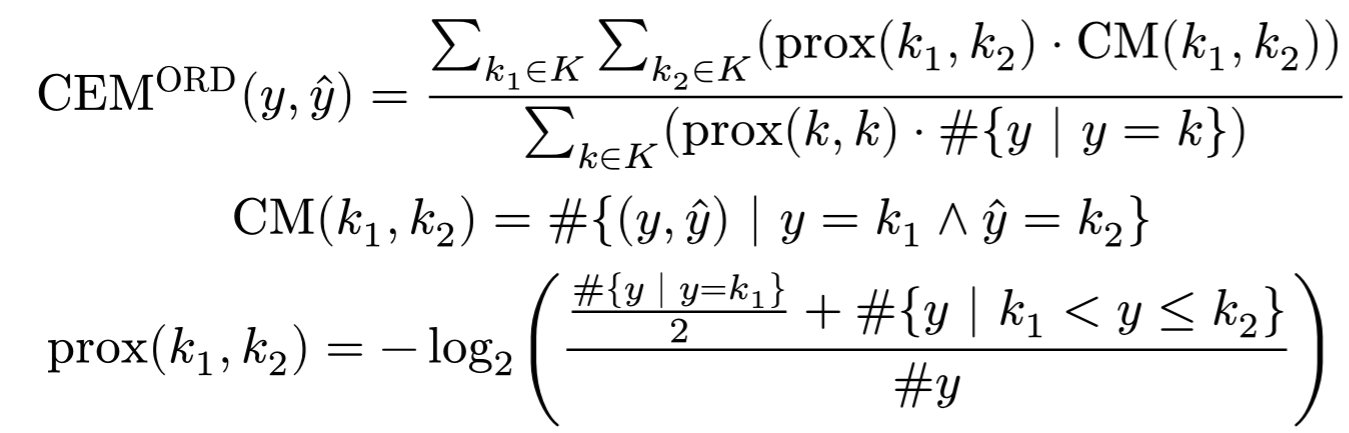

In [ ]:
def CEM(y_real: Series, y_pred: Series) -> float:
  def prox(k_1, k_2):
    return -np.log2(
      (y_real[y_real.eq(k_1)].count()/2 + y_real[y_real.between(k_1, k_2, inclusive="right")].count()) / y_real.count()
    )
  def CM(k_1, k_2):
    return y_real[y_real.eq(k_1) & y_pred.eq(k_2)].count()
  
  return sum(
    prox(k_1, k_2) * CM(k_1, k_2)
    for k_1 in y_real.unique()
    for k_2 in y_real.unique()
  )/sum(
    prox(k, k) * y_real[y_real.eq(k)].count()
    for k in y_real.unique()
  )